In [14]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from stable_baselines3 import PPO
from tqdm import tqdm

sys.path.append('../')
from env import *
from curriculum import *


def extract_plot_vals(row):
    traj_lens = [len(traj) for traj in row['runs']]

    return pd.Series([
        row['name'],
        traj_lens
    ], index=['name', 'traj_lens'])


def make_plot(df):
    plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')

    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    ax = sns.barplot(plot_df, x='name', y='traj_lens', ax=axs[0])
    ax.set_ylabel('Steps')
    ax.set_xlabel('')

    x_labs = ax.get_xticklabels()
    x_labs[0] = 'Adaptive'
    ax.set_xticklabels(x_labs)
    ax.set_title('Benchmarks')

    ### PLOT TRAJECTORIES
    for k, row in df.iterrows():
        if k == 2:
            break

        for i, traj in enumerate(row['runs']):
            if i == 0:
                axs[1].plot(traj, label=row['name'], color=f'C{k}', alpha=0.5)
            else:
                axs[1].plot(traj, color=f'C{k}', alpha=0.6)

    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Difficulty index')
    axs[1].legend(loc='lower right')
    axs[1].set_title('Trajectory')

    fig.tight_layout()

"""Ensure all data files are located here"""
data_dir = Path('data/')

# Benchmark plots

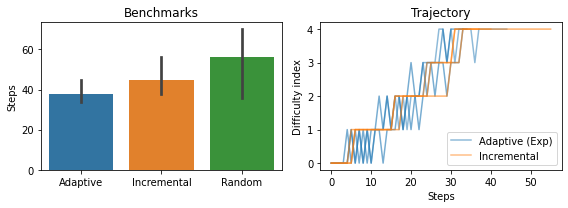

In [5]:
df = pd.read_pickle(data_dir / 'meander_results.pkl')
make_plot(df)

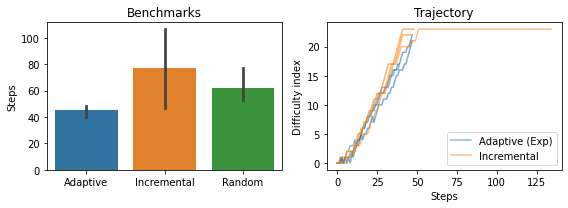

In [6]:
df = pd.read_pickle(data_dir / 'plume_results.pkl')
make_plot(df)

# Plot sample runs

In [16]:
"""Meander trail"""

model_path = data_dir / 'meander_agent.zip'
save_path = Path('trail_examples/')
if not path.exists():
    path.mkdir()

if not save_path.exists():
    save_path.mkdir()

trail_args = {
    'width': 5,
    'diff_rate': 0.02,
    'radius': 70,
    'reward_dist': -1,
    'range': (-np.pi, np.pi),
    'length': 500,
    'breaks': [(0.3, 0.32), (0.5, 0.53), (0.7, 0.72)]   
}

model = PPO.load(model_path, device='cpu')

"""Determine how many sample runs you would like"""
n_samps = 5

for i in tqdm(range(n_samps)):
    plt.clf()
    maps = []
    position_hists = []

    trail_map = MeanderTrail(**trail_args, heading=0)
    trail_map.max_steps = 1000

    env = TrailEnv(trail_map, discrete=True, treadmill=True)
    

    obs = env.reset()
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, is_done, _ = env.step(action)

        if is_done:
            break

    maps.append(trail_map)
    position_hists.append(np.array(env.agent.position_history))

    fig, axs = plt.subplots(1, 1, figsize=(6, 12))

    for ax, m, p_hist in zip([axs], maps, position_hists):
        y_min = np.min(m.y_coords)
        y_max = np.max(m.y_coords)

        x_min = np.min(m.x_coords)
        x_max = np.max(m.x_coords)

        m.plot(ax=ax, xmin=x_min-20, xmax=x_max+20, ymin=y_min - 20, ymax=y_max + 20)
        ax.plot(p_hist[:,0], p_hist[:,1], linewidth=2, color='black')

    ratio = (y_max - y_min + 40) / (x_max - x_min + 40)
    height = 6 * ratio

    fig.set_size_inches((6, height))
    fig.tight_layout()

    plt.axis('off')
    plt.savefig(str(save_path / f'example_{i}.png'))
    # np.save(str(path / f'positions_{i}.npy'), p_hist)
    # with (path / f'map_{i}.pkl').open('wb') as fp:
    #     pickle.dump(m, fp)


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.30s/it]


<Figure size 432x691.183 with 0 Axes>

In [29]:
"""Plume trail"""

model_path = data_dir / 'plume_agent.zip'

save_path = Path(f'plume_examples/')
if not path.exists():
    path.mkdir()

if not save_path.exists():
    save_path.mkdir()
    
trail_args = {
    'wind_speed': 5,
    'length_scale': 20,
    'range': (-np.pi, np.pi),
    'max_steps': 'auto',
    'start_rate': 0.3
}


model = PPO.load(model_path, device='cpu')
n_samps = 5


for i in tqdm(range(n_samps)):

    maps = []
    position_hists = []
    odor_hists = []

    trail_map = PlumeTrail(**trail_args)

    env = TrailEnv(trail_map, discrete=True, treadmill=True)
    

    obs = env.reset()
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, is_done, _ = env.step(action)

        if is_done:
            break

    maps.append(trail_map)
    position_hists.append(np.array(env.agent.position_history))
    odor_hists.append(env.agent.odor_history)

    fig, axs = plt.subplots(1, 1, figsize=(6, 12))

    for ax, m, p_hist, odor_hist in zip([axs], maps, position_hists, odor_hists):
        odor_hist = np.array(odor_hist)
        odor_hist = odor_hist[odor_hist[:,0] > 0]

        x_min = min(-30, np.min(p_hist[:,0]))
        x_max = max(30, np.max(p_hist[:,0]))

        y_min = min(-50, np.min(p_hist[:,1]))
        y_max = max(10, np.max(p_hist[:,1]))

        m.plot(ax=ax, x_lim=(x_min-20, x_max+20), y_lim=(y_min - 20, y_max + 20))
        ax.plot(p_hist[:,0], p_hist[:,1], linewidth=2, color='black')
        ax.scatter(odor_hist[:,1], odor_hist[:,2], c=[np.log(o) for o in odor_hist[:,0]], cmap='summer', s=30)

    ratio = (y_max - y_min + 40) / (x_max - x_min + 40)
    height = 6 * ratio

    fig.set_size_inches((6, height))
    fig.tight_layout()

    plt.axis('off')
    plt.savefig(str(save_path / f'example_{i}.png'))
    # np.save(str(path / f'positions_{i}.npy'), p_hist)
    # with (path / f'map_{i}.pkl').open('wb') as fp:
    #     pickle.dump(m, fp)
    
    plt.clf()

  0%|                                                     | 0/5 [00:00<?, ?it/s]/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_30433/1909402067.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  odor_hist = np.array(odor_hist)
 20%|█████████                                    | 1/5 [00:02<00:08,  2.20s/it]/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/numpy/core/shape_base.py:121: Visible

<Figure size 432x481.54 with 0 Axes>

<Figure size 432x409.833 with 0 Axes>

<Figure size 432x712.85 with 0 Axes>

<Figure size 432x335.328 with 0 Axes>

<Figure size 432x581.567 with 0 Axes>